Running simulation for 10 nodes to poll...
Completed simulation for 10 nodes to poll.
Nodes to poll: 10
  Average MSE: 5.408930127523334
  Average sensor lifetime (years): 4.124272696964848


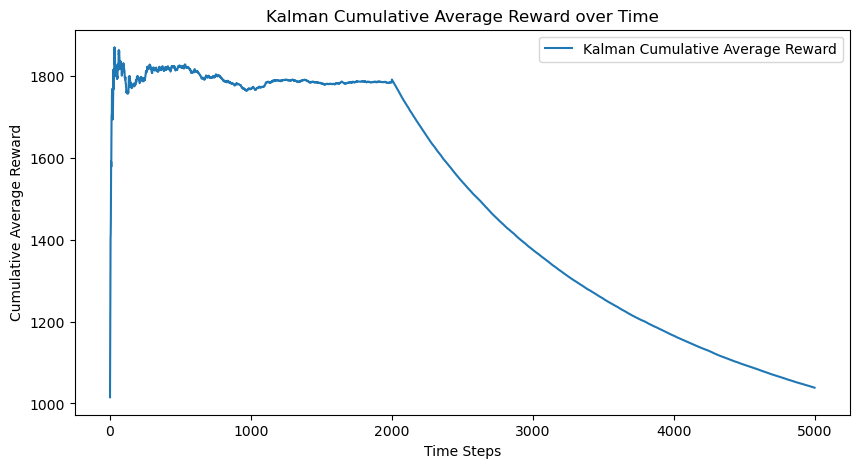

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#pivot_df = pd.read_csv('simulated_sensor_data.csv')
#pivot_df = pd.read_csv('synthetic_dataset.csv')
#pivot_df = pd.read_csv('top_fifty_motes_temperatures.csv')
pivot_df = pd.read_csv('synthetic_dataset_two.csv')
#pivot_df = pd.read_csv('top_fifty_motes_humidity.csv')
#pivot_df = pivot_df.head(10000)

alpha = 15  # Set your desired alpha value
beta = 5  # Set your desired beta value

# Parameters
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance

theta = 0.5                             # Threshold for significant change
num_nodes_to_poll_list = [10]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 10 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}  # Initialize to zeros
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    valuable_sensor_data = []
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    cumulative_reward = []

    def predict_node_state(x_hat, delta_t):
        A = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix
        return A @ x_hat

    def select_top_nodes(state_estimates, P, num_nodes_to_poll, currently_polled_nodes):
        covariance_traces = {mote: np.trace(P[mote]) for mote in state_estimates}
        sorted_motes_by_trace = sorted(covariance_traces, key=covariance_traces.get, reverse=True)
        top_nodes = set(sorted_motes_by_trace[:num_nodes_to_poll])
        return top_nodes 
        #return top_nodes | currently_polled_nodes 

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        top_sensors = select_top_nodes(state_estimates, P, num_nodes_to_poll, currently_polled_nodes)

        total_reward_for_round = 0
        for mote in top_sensors:
            polled_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)
            
            A = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix
            xp = A @ previous_state
            Pp = A @ previous_P @ A.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            # Corrected section
            last_value = last_sensed_values[mote]
            diff = abs(measured_value - last_value)*alpha
            weighted_time =  beta/delta_t
            R_s = diff* weighted_time

            if abs(measured_value - last_value) > theta:  # Add reward only if it exceeds the threshold
                total_reward_for_round += (R_s-2)
                transmitted_count[mote] += 1
                last_sensed_values[mote] = measured_value

                valuable_sensor_data.append({
                    'index': current_time_step,
                    'selected_moteid': mote,
                    'temperature': measured_value,
                    'predicted_temperature': x_hat[0, 0],  # Still keep the predicted temperature for analysis
                    'time_elapsed': delta_t
                })
            else :
                total_reward_for_round -= 2

            currently_polled_nodes.add(mote)
            last_update_times[mote] = current_time_step

        cumulative_reward.append(total_reward_for_round)

    valuable_sensor_df = pd.DataFrame(valuable_sensor_data)
    valuable_sensor_df['squared_error'] = (valuable_sensor_df['temperature'] - valuable_sensor_df['predicted_temperature']) ** 2
    average_mse = valuable_sensor_df['squared_error'].mean()

    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    return average_mse, average_lifetime_years, cumulative_reward

results = {}
valuable_sensor_df_list = []
cumulative_rewards_kalman = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    mse, lifetime, cumulative_reward = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse, 'Lifetime (years)': lifetime}
    cumulative_rewards_kalman.append(cumulative_reward)
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Print the results
for num_nodes_to_poll, metrics in results.items():
    print(f"Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")

# Save cumulative rewards for Kalman to CSV
pd.DataFrame(cumulative_rewards_kalman[0], columns=["cumulative_reward"]).to_csv('cumulative_rewards_kalman.csv', index=False)

# Calculate cumulative reward and cumulative average reward for Kalman
cumulative_reward_array_kalman = np.cumsum(cumulative_rewards_kalman[0])
cumulative_average_reward_kalman = cumulative_reward_array_kalman / (np.arange(len(cumulative_reward_array_kalman)) + 1)

# Plot cumulative average reward over time for Kalman
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_average_reward_kalman)), cumulative_average_reward_kalman, label='Kalman Cumulative Average Reward')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Average Reward')
plt.title('Kalman Cumulative Average Reward over Time')
plt.legend()
plt.show()


Running simulation for 10 nodes to poll...
Completed simulation for 10 nodes to poll.
Nodes to poll: 10
  Average MSE: 3.188623763894558
  Average sensor lifetime (years): 0.3267062005824517


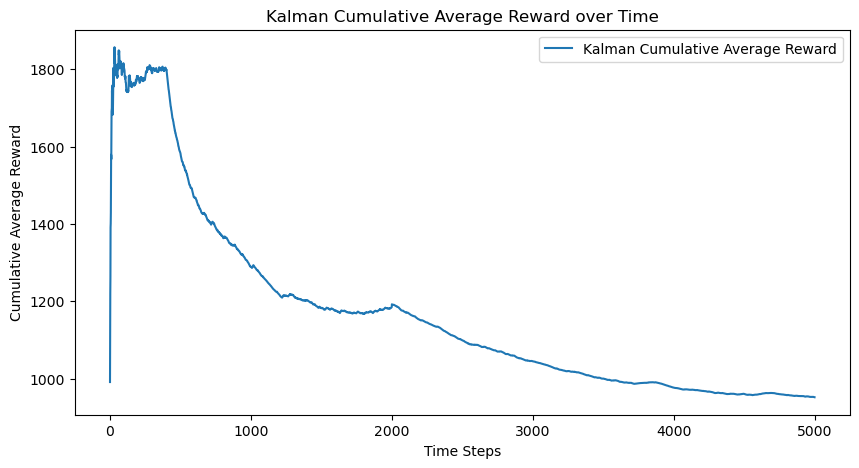

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
pivot_df = pd.read_csv('synthetic_dataset_two.csv')

# Parameters
alpha = 15
beta = 5
H = np.array([[1, 0]])                # Measurement matrix
Q = np.array([[1e-5, 0], [0, 1e-5]])  # Process noise covariance
R = np.array([[0.5]])                 # Measurement noise covariance
theta = 0.5                           # Threshold for significant change
num_nodes_to_poll_list = [10]         # List of numbers of nodes to poll
force_pull_threshold = 200            # Forcefully pull a node if it hasn't been pulled in the last 200 time steps

# Energy parameters in Joules
E_max = 162000  # Battery capacity in Joules
E_t = 50 / 1000  # Transmission energy in Joules
E_s = 10 / 1000  # Sensing energy in Joules
E_w = 10 / 1000  # Wake-up energy in Joules
E_0 = 1 / 1000   # Sleep energy in Joules

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

def run_simulation(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}  # Initialize to zeros
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    cumulative_reward = []
    cumulative_squared_error = 0
    total_measurements = 0

    def predict_node_state(x_hat, delta_t):
        A = get_state_transition_matrix(delta_t)  # Get the dynamic state transition matrix
        return A @ x_hat

    def select_top_nodes(state_estimates, P, num_nodes_to_poll, currently_polled_nodes):
        covariance_traces = {mote: np.trace(P[mote]) for mote in state_estimates}
        sorted_motes_by_trace = sorted(covariance_traces, key=covariance_traces.get, reverse=True)
        top_nodes = set(sorted_motes_by_trace[:num_nodes_to_poll])
        #return top_nodes
        return top_nodes | currently_polled_nodes 

    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        top_sensors = select_top_nodes(state_estimates, P, num_nodes_to_poll, currently_polled_nodes)

        total_reward_for_round = 0
        for mote in top_sensors:
            polled_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)

            # State prediction and update using Kalman filter
            A = get_state_transition_matrix(delta_t)
            xp = A @ previous_state
            Pp = A @ previous_P @ A.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat

            # Reward computation
            last_value = last_sensed_values[mote]
            diff = abs(measured_value - last_value) * alpha
            weighted_time = beta / delta_t
            R_s = diff * weighted_time

            if abs(measured_value - last_value) > theta:  # Add reward only if it exceeds the threshold
                total_reward_for_round += (R_s - 2)
                transmitted_count[mote] += 1
                last_sensed_values[mote] = measured_value
            else:
                total_reward_for_round -= 10

            # Compute squared error for MSE calculation
            squared_error = (measured_value - x_hat[0, 0]) ** 2
            cumulative_squared_error += squared_error
            total_measurements += 1

            currently_polled_nodes.add(mote)
            last_update_times[mote] = current_time_step

        cumulative_reward.append(total_reward_for_round)

    average_mse = cumulative_squared_error / total_measurements if total_measurements > 0 else float('nan')

    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    return average_mse, average_lifetime_years, cumulative_reward

results = {}
cumulative_rewards_kalman = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation for {num_nodes_to_poll} nodes to poll...")
    mse, lifetime, cumulative_reward = run_simulation(num_nodes_to_poll)
    results[num_nodes_to_poll] = {'MSE': mse, 'Lifetime (years)': lifetime}
    cumulative_rewards_kalman.append(cumulative_reward)
    print(f"Completed simulation for {num_nodes_to_poll} nodes to poll.")

# Print the results
for num_nodes_to_poll, metrics in results.items():
    print(f"Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")

# Save cumulative rewards for Kalman to CSV
pd.DataFrame(cumulative_rewards_kalman[0], columns=["cumulative_reward"]).to_csv('cumulative_rewards_kalman.csv', index=False)

# Calculate cumulative reward and cumulative average reward for Kalman
cumulative_reward_array_kalman = np.cumsum(cumulative_rewards_kalman[0])
cumulative_average_reward_kalman = cumulative_reward_array_kalman / (np.arange(len(cumulative_reward_array_kalman)) + 1)

# Plot cumulative average reward over time for Kalman
plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_average_reward_kalman)), cumulative_average_reward_kalman, label='Kalman Cumulative Average Reward')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Average Reward')
plt.title('Kalman Cumulative Average Reward over Time')
plt.legend()
plt.show()


Running simulation with information sharing for 10 nodes to poll...
Completed simulation with information sharing for 10 nodes to poll.
With Information Sharing - Nodes to poll: 10
  Average MSE: 6.868898899279604
  Average sensor lifetime (years): 2.425096498149446


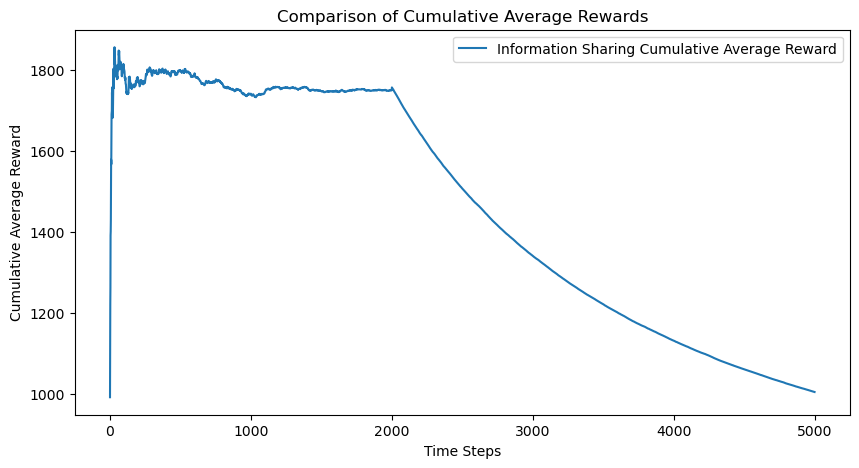

: 

In [11]:
from scipy.linalg import norm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
pivot_df = pd.read_csv('synthetic_dataset_two.csv')

# Parameters
alpha = 15
beta = 5
H = np.array([[1, 0]])
Q = np.array([[1e-5, 0], [0, 1e-5]])
R = np.array([[0.5]])
theta = 0.5
num_nodes_to_poll_list = [10]
force_pull_threshold = 200

# Energy parameters in Joules
E_max = 162000
E_t = 50 / 1000
E_s = 10 / 1000
E_w = 10 / 1000
E_0 = 1 / 1000

def get_state_transition_matrix(delta_t):
    return np.array([[1, delta_t], [0, 1]])

# Method with information sharing
def run_simulation_with_sharing(num_nodes_to_poll):
    state_estimates = {f'mote{i}': np.array([[20], [0.01]]) for i in range(1, 51)}
    P = {f'mote{i}': np.zeros((2, 2)) for i in range(1, 51)}
    last_sensed_values = {f'mote{i}': 20.0 for i in range(1, 51)}
    last_update_times = {f'mote{i}': 0 for i in range(1, 51)}
    polled_count = {f'mote{i}': 0 for i in range(1, 51)}
    transmitted_count = {f'mote{i}': 0 for i in range(1, 51)}
    cumulative_reward = []
    cumulative_squared_error = 0
    total_measurements = 0

    def predict_node_state(x_hat, delta_t):
        A = get_state_transition_matrix(delta_t)
        return A @ x_hat

    def find_similar_covariance_nodes(P, polled_node, unpolled_node):
        return norm(P[polled_node] - P[unpolled_node], 'fro')

    def select_top_nodes(state_estimates, P, num_nodes_to_poll, currently_polled_nodes):
        covariance_traces = {mote: np.trace(P[mote]) for mote in state_estimates}
        sorted_motes_by_trace = sorted(covariance_traces, key=covariance_traces.get, reverse=True)
        top_nodes = set(sorted_motes_by_trace[:num_nodes_to_poll])
        #return top_nodes
        return top_nodes | currently_polled_nodes 


    for idx, row in pivot_df.iterrows():
        current_time_step = idx
        currently_polled_nodes = set()

        for mote, last_time in last_update_times.items():
            if current_time_step - last_time >= force_pull_threshold:
                currently_polled_nodes.add(mote)

        top_sensors = select_top_nodes(state_estimates, P, num_nodes_to_poll, currently_polled_nodes)

        total_reward_for_round = 0
        polled_nodes = []

        for mote in top_sensors:
            polled_count[mote] += 1
            measured_value = row[mote]
            previous_state = state_estimates[mote]
            previous_P = P[mote]
            delta_t = max(current_time_step - last_update_times[mote], 1)

            A = get_state_transition_matrix(delta_t)
            xp = A @ previous_state
            Pp = A @ previous_P @ A.T + Q

            z = np.array([[measured_value]])
            K = Pp @ H.T @ np.linalg.inv(H @ Pp @ H.T + R)
            x_hat = xp + K @ (z - H @ xp)
            P_hat = Pp - K @ H @ Pp

            state_estimates[mote] = x_hat
            P[mote] = P_hat
            polled_nodes.append(mote)

            last_update_times[mote] = current_time_step

            # Calculate reward
            last_value = last_sensed_values[mote]
            diff = abs(measured_value - last_value) * alpha
            weighted_time = beta / delta_t
            R_s = diff * weighted_time

            if abs(measured_value - last_value) > theta:  # Add reward only if it exceeds the threshold
                total_reward_for_round += (R_s - 2)
                transmitted_count[mote] += 1
                last_sensed_values[mote] = measured_value
            else:
                total_reward_for_round -= 10

            # Calculate the squared error directly
            squared_error = (measured_value - x_hat[0, 0]) ** 2
            cumulative_squared_error += squared_error
            total_measurements += 1

        # Update states of unpolled nodes based on similarity to polled nodes
        for mote in state_estimates.keys():
            if mote not in polled_nodes:
                similarities = {polled_node: find_similar_covariance_nodes(P, polled_node, mote) for polled_node in polled_nodes}
                most_similar_node = min(similarities, key=similarities.get)

                state_estimates[mote] = state_estimates[most_similar_node]
                P[mote] = P[most_similar_node]

        cumulative_reward.append(total_reward_for_round)

    average_mse = cumulative_squared_error / total_measurements if total_measurements > 0 else float('nan')

    time_steps = len(pivot_df)
    fw = {mote: polled_count[mote] / time_steps for mote in polled_count}
    ft = {mote: transmitted_count[mote] / time_steps for mote in transmitted_count}

    average_lifetime_hours = np.mean([
        E_max / (ft[mote] * E_t + fw[mote] * (E_s + 3 * E_w) + (1 - fw[mote]) * E_0) for mote in polled_count
    ]) / 3600

    average_lifetime_years = average_lifetime_hours / 8760

    return average_mse, average_lifetime_years, cumulative_reward

# Running both methods for comparison
results_with_sharing = {}
cumulative_rewards_with_sharing = []

for num_nodes_to_poll in num_nodes_to_poll_list:
    print(f"Running simulation with information sharing for {num_nodes_to_poll} nodes to poll...")
    mse_with_sharing, lifetime_with_sharing, cumulative_reward_with_sharing = run_simulation_with_sharing(num_nodes_to_poll)
    results_with_sharing[num_nodes_to_poll] = {'MSE': mse_with_sharing, 'Lifetime (years)': lifetime_with_sharing}
    cumulative_rewards_with_sharing.append(cumulative_reward_with_sharing)
    print(f"Completed simulation with information sharing for {num_nodes_to_poll} nodes to poll.")

# Print and compare the results
for num_nodes_to_poll, metrics in results_with_sharing.items():
    print(f"With Information Sharing - Nodes to poll: {num_nodes_to_poll}")
    print(f"  Average MSE: {metrics['MSE']}")
    print(f"  Average sensor lifetime (years): {metrics['Lifetime (years)']}")

# Save cumulative rewards for Information Sharing to CSV
pd.DataFrame(cumulative_rewards_with_sharing[0], columns=["cumulative_reward"]).to_csv('cumulative_rewards_with_sharing.csv', index=False)

# Plot cumulative average reward over time for both methods
cumulative_reward_array_with_sharing = np.cumsum(cumulative_rewards_with_sharing[0])
cumulative_average_reward_with_sharing = cumulative_reward_array_with_sharing / (np.arange(len(cumulative_reward_array_with_sharing)) + 1)

plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_average_reward_with_sharing)), cumulative_average_reward_with_sharing, label='Information Sharing Cumulative Average Reward')
plt.xlabel('Time Steps')
plt.ylabel('Cumulative Average Reward')
plt.title('Comparison of Cumulative Average Rewards')
plt.legend()
plt.show()
